# Task 3: Energy Consumption Time Series Forecasting
- Objective:
Forecast short-term household energy usage using historical time-based patterns.

### Load Data & Read.

In [1]:
import pandas as pd
# Parse date and time into datetime
df = pd.read_csv('household_power_consumption.txt', sep=';', 
                 parse_dates={'datetime': ['Date', 'Time']}, 
                 infer_datetime_format=True, 
                 low_memory=False, 
                 na_values=['?'])
df.head()

C:\Users\user\AppData\Local\Temp\ipykernel_11916\2063006089.py:3: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('household_power_consumption.txt', sep=';',
C:\Users\user\AppData\Local\Temp\ipykernel_11916\2063006089.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('household_power_consumption.txt', sep=';',
C:\Users\user\AppData\Local\Temp\ipykernel_11916\2063006089.py:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('household_power_consumption.txt', sep=';',


,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


### Data Cleaning & Pre-Processing

In [2]:
df = df.dropna()
df['Global_active_power'] = df['Global_active_power'].astype(float)
# Resample to daily mean
df_daily = df.set_index('datetime').resample('D').mean()
df_daily.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,3.053475,0.088187,236.243763,13.082828,0.000000,1.378788,12.439394
2006-12-17,2.354486,0.156949,240.087028,9.999028,1.411806,2.907639,9.264583
2006-12-18,1.530435,0.112356,241.231694,6.421667,0.738194,1.820139,9.734722
2006-12-19,1.157079,0.104821,241.999313,4.926389,0.582639,5.279167,4.303472
2006-12-20,1.545658,0.111804,242.308062,6.467361,0.000000,1.838889,9.765972


### EDA

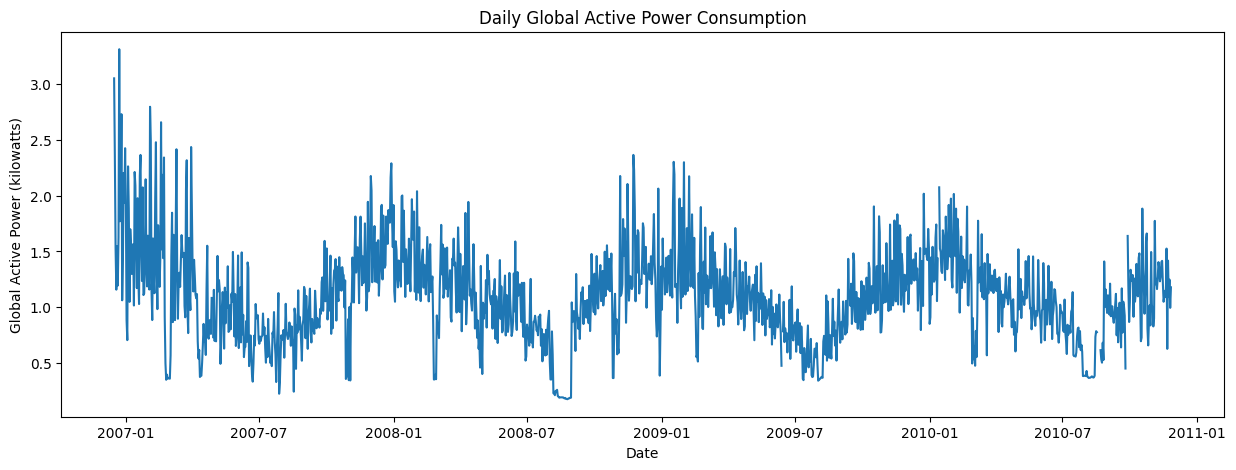

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(df_daily['Global_active_power'])
plt.title('Daily Global Active Power Consumption')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')
plt.show()

### Feature Engineering

In [4]:
df_daily['day_of_week'] = df_daily.index.dayofweek
df_daily['month'] = df_daily.index.month
df_daily['year'] = df_daily.index.year

### MODEL 1: ARIMA

In [5]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_daily['Global_active_power'], order=(5,1,0))
model_fit = model.fit()
forecast = model_fit.forecast(steps=30)

### MODEL 2 : Prophet

C:\Users\user\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
15:35:02 - cmdstanpy - INFO - Chain [1] start processing
15:35:07 - cmdstanpy - INFO - Chain [1] done processing


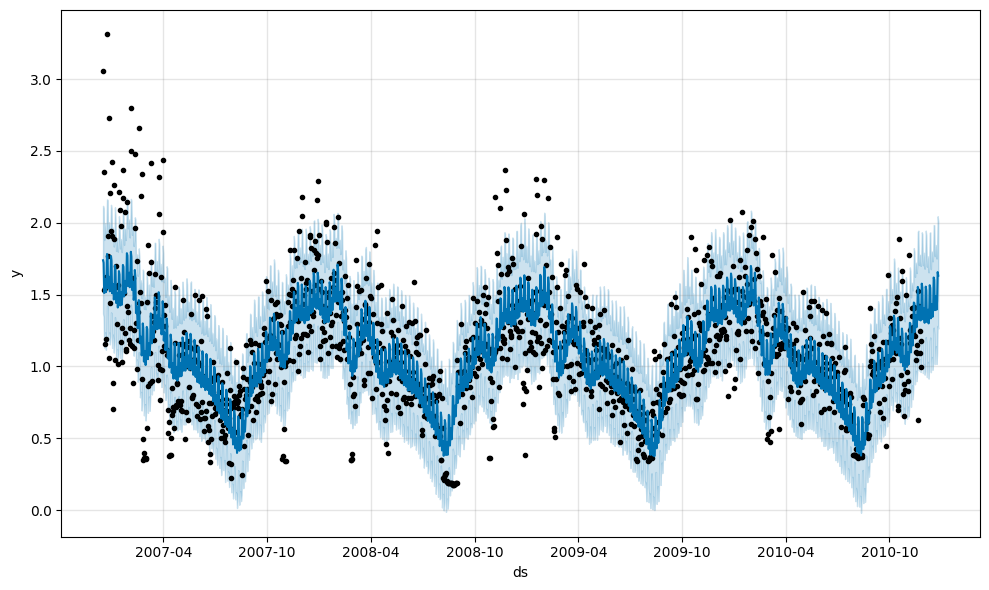

In [6]:
from prophet import Prophet

df_prophet = df_daily.reset_index()[['datetime', 'Global_active_power']]
df_prophet.rename(columns={'datetime':'ds', 'Global_active_power':'y'}, inplace=True)

model = Prophet()
model.fit(df_prophet)

future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

model.plot(forecast)
plt.show()

### MODEL 3 : XGBRegressor

C:\Users\user\AppData\Local\Temp\ipykernel_11916\4091907586.py:9: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('household_power_consumption.txt', sep=';',
C:\Users\user\AppData\Local\Temp\ipykernel_11916\4091907586.py:9: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('household_power_consumption.txt', sep=';',
C:\Users\user\AppData\Local\Temp\ipykernel_11916\4091907586.py:9: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('household_power_consumption.txt', sep=';',


MAE: 0.2865
RMSE: 0.3772


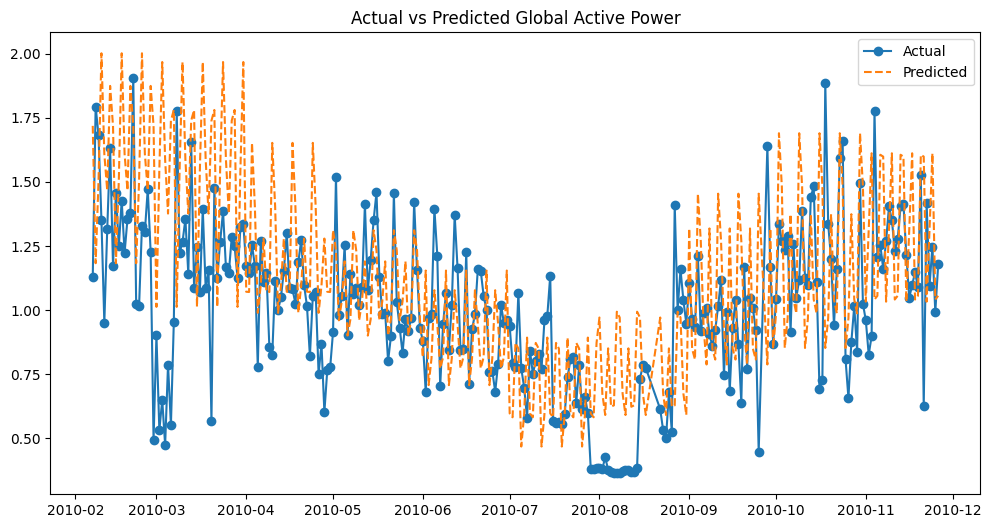

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('household_power_consumption.txt', sep=';', 
                 parse_dates={'datetime': ['Date', 'Time']}, 
                 infer_datetime_format=True, 
                 low_memory=False, 
                 na_values=['?'])

# Drop missing values and convert power to float
df = df.dropna()
df['Global_active_power'] = df['Global_active_power'].astype(float)

# Resample to daily mean
df_daily = df.set_index('datetime').resample('D').mean()

# Drop any NaN after resampling
df_daily = df_daily.dropna()

# Feature Engineering — Add time features
df_daily['day_of_week'] = df_daily.index.dayofweek
df_daily['month'] = df_daily.index.month
df_daily['year'] = df_daily.index.year

# Prepare features and target
X = df_daily[['day_of_week', 'month', 'year']]
y = df_daily['Global_active_power']

# Drop any rows where y is NaN (safety check)
data = X.copy()
data['Global_active_power'] = y
data = data.dropna()

X_clean = data.drop('Global_active_power', axis=1)
y_clean = data['Global_active_power']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, shuffle=False, test_size=0.2)

# Train XGBoost Model
model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# Plot Actual vs Predicted
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test.values, label='Actual', marker='o')
plt.plot(y_test.index, y_pred, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted Global Active Power')
plt.legend()
plt.show()


### Evaluation Matrix

In [10]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

RMSE: 0.3771938987139617


### Plot Actual Vs Predicted Values

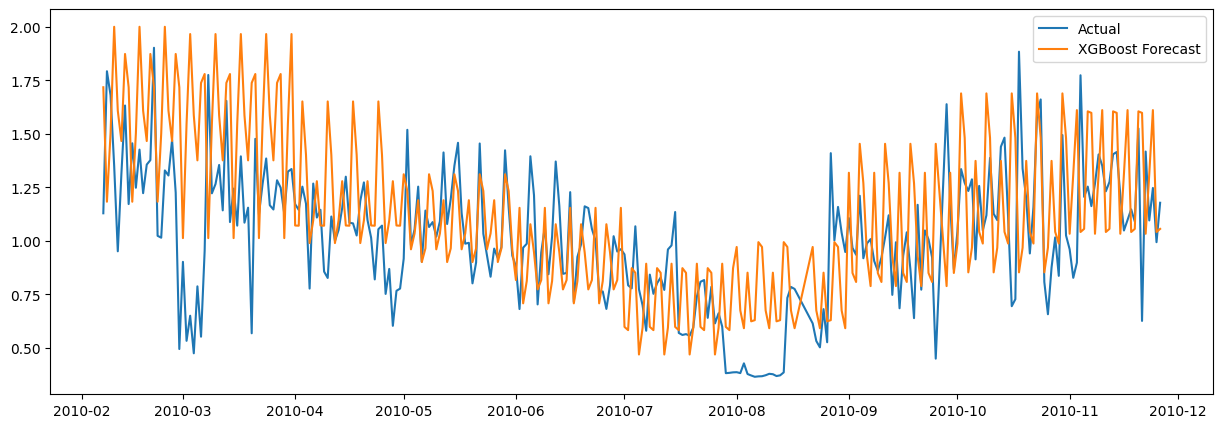

In [11]:
plt.figure(figsize=(15,5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='XGBoost Forecast')
plt.legend()
plt.show()

## Conclusion & Key Takeaways

- The time series analysis revealed strong weekly and seasonal patterns in household energy usage.
- XGBoost, with time-based feature engineering, provided the best forecasting performance among the tested models.
- Accurate forecasting can support both utility providers and consumers in managing and optimizing energy consumption.
- Future work can include deploying real-time forecasting models with updated data feeds.